In [1]:
import numpy as np
import pandas as pd 
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize']=(10,6)
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns


In [2]:
goog=pdr.get_data_yahoo('GOOG','20190101') 

In [3]:
goog.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 259 entries, 2019-01-02 to 2020-01-10
Data columns (total 6 columns):
High         259 non-null float64
Low          259 non-null float64
Open         259 non-null float64
Close        259 non-null float64
Volume       259 non-null int64
Adj Close    259 non-null float64
dtypes: float64(5), int64(1)
memory usage: 14.2 KB


In [4]:
goog.drop(columns=['Adj Close'],inplace = True)# Google has never had a stock splig

In [5]:
goog['Change']=goog.Close.diff()
goog['Return']=np.log(goog.Close).diff()
goog['Volatility']=goog['Return'].rolling(21).std()
goog['Exp Change'] = (goog.Close*goog.Volatility).shift(1)
goog['Magnitude']=goog.Change/goog['Exp Change']
goog['Abs Magnitude'] = np.abs(goog.Magnitude)

In [6]:
goog.dropna(inplace=True)
goog.head()

,High,Low,Open,Close,Volume,Change,Return,Volatility,Exp Change,Magnitude,Abs Magnitude
Date,,,,,,,,,,,
2019-02-04,1132.800049,1109.020020,1112.660034,1132.800049,2576500,22.050049,0.019657,0.018351,21.615776,1.020091,1.020091
2019-02-05,1146.849976,1117.248047,1124.839966,1145.989990,3552200,13.189941,0.011576,0.014946,20.787578,0.634511,0.634511
2019-02-06,1147.000000,1112.770020,1139.569946,1115.229980,2105600,-30.760010,-0.027208,0.016333,17.128003,-1.795890,1.795890
2019-02-07,1104.839966,1086.000000,1104.160034,1098.709961,2044800,-16.520020,-0.014924,0.016690,18.215222,-0.906935,0.906935
2019-02-08,1098.910034,1086.550049,1087.000000,1095.060059,1075800,-3.649902,-0.003328,0.016709,18.337984,-0.199035,0.199035


In [7]:
goog.Magnitude.describe()

count    237.000000
mean       0.126245
std        1.445810
min      -11.971994
25%       -0.437585
50%        0.059718
75%        0.659695
max       12.320565
Name: Magnitude, dtype: float64

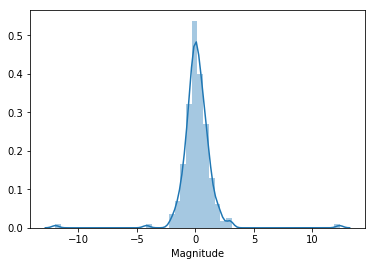

In [8]:
sns.distplot(goog.Magnitude);

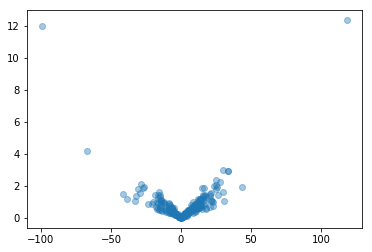

In [9]:
plt.scatter(x=goog.Change,y=goog['Abs Magnitude'],alpha=0.4);

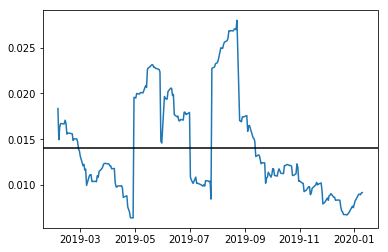

In [10]:
date=np.array(goog.index)
plt.plot(goog.Volatility)
plt.axhline(goog.Volatility.mean(),c='k');

##### Advance Transformations!!

In [11]:
import datetime as dt

In [12]:
default_date = dt.date.isoformat(dt.date.today() -dt.timedelta(397))

In [27]:
def get_data(symbol,date=default_date):
    data = pdr.get_data_yahoo(symbol,start=date)
    return data

def calc_vol(df,n=21):
    """
    Calculate rolling window volatility (STD), and
    add related columns. Default is 21 days rollback.
    """
    df['Return']=np.log(df.Close).diff()
    df['Volatility'] = df['Return'].rolling(n).std()
    df['Change']= df.Close.diff()
    df['Exp_Change'] = (df.Volatility-df.Close).shift(1)
    df['Magnitude']=df['Change']/df.Exp_Change
    df['Abs_Magnitude'] =np.abs(df.Magnitude)

def high_low(df):
    df['High_Low_Spread'] = (df['High']-df['Low'])/df.Close
def exp_friday(df):
    mask=np.where((df.index.day>14)&
                  (df.index.day>22)&
                  (df.index.dayofweek==4),True,False)
    return df[mask]
    #Meets all 3 conditions for options 
def low_vol_duration(df):
    pd.set_option('mode.chained_assignment',None)
    df['Days<2sd']=0
    count=0
    for row in range(len(df)):
        if df['Magnitude'].iloc[row] < 2:
            count+=1
            df['Days<2sd'].iloc[row]= count
        else:
            df['Days<2sd'].iloc[row]=count
            count+=1
    return df[df.Magnitude >=2]

In [28]:
fb=round(get_data('FB'),2)
calc_vol(fb)
high_low(fb)
fb.head()

,High,Low,Open,Close,Volume,Adj Close,Return,Volatility,Change,Exp_Change,Magnitude,Abs_Magnitude,High_Low_Spread
Date,,,,,,,,,,,,,
2018-12-11,143.88,141.10,143.88,142.08,20300300,142.08,NaN,NaN,NaN,NaN,NaN,NaN,0.019566
2018-12-12,147.19,142.51,143.08,144.50,23696900,144.50,0.016889,NaN,2.42,NaN,NaN,NaN,0.032388
2018-12-13,145.85,143.19,145.57,145.01,18148600,145.01,0.003523,NaN,0.51,NaN,NaN,NaN,0.018344
2018-12-14,146.01,142.51,143.34,144.06,21785800,144.06,-0.006573,NaN,-0.95,NaN,NaN,NaN,0.024295
2018-12-17,144.92,138.42,143.08,140.19,24334000,140.19,-0.027231,NaN,-3.87,NaN,NaN,NaN,0.046366


In [29]:
fb.dropna(inplace=True)
len(fb)

251

In [30]:
exp_fri=exp_friday(fb)
exp_fri[['Return','Change','Magnitude','Close']]

,Return,Change,Magnitude,Close
Date,,,,
2019-01-25,0.021572,3.18,-0.021810,149.01
2019-03-29,0.006863,1.14,-0.006887,166.69
2019-04-26,-0.009201,-1.77,0.009159,191.49
2019-05-24,0.001050,0.19,-0.001051,181.06
2019-05-31,-0.030739,-5.54,0.030274,177.47
2019-06-28,0.018301,3.50,-0.018472,193.00
2019-07-26,-0.004794,-0.96,0.004783,199.75
2019-08-23,-0.023848,-4.29,0.023569,177.75
2019-08-30,0.000539,0.10,-0.000539,185.67


In [32]:
big_days = low_vol_duration(goog)
big_days

,High,Low,Open,Close,Volume,Change,Return,Volatility,Exp Change,Magnitude,Abs Magnitude,Daysc2sd,Days<2sd
Date,,,,,,,,,,,,,
2019-03-11,1176.189941,1144.449951,1144.449951,1175.760010,1719200,33.440063,0.028854,0.010978,11.399984,2.933343,2.933343,24,24
2019-03-20,1227.140015,1196.170044,1197.349976,1223.969971,2227400,25.119995,0.020737,0.011028,12.427647,2.021299,2.021299,31,31
2019-07-26,1265.550049,1224.000000,1224.040039,1250.410034,4805800,118.290039,0.099380,0.022732,9.601024,12.320565,12.320565,120,120
2019-09-25,1248.300049,1210.089966,1215.819946,1246.520020,1453000,27.760010,0.022522,0.010771,12.445846,2.230464,2.230464,162,162
2019-12-04,1325.800049,1304.869995,1307.010010,1320.540039,1537500,25.260010,0.019314,0.008854,10.814862,2.335676,2.335676,211,211
2020-01-02,1368.140015,1341.550049,1341.550049,1367.369995,1406600,30.349976,0.022446,0.008288,10.086928,3.008842,3.008842,230,230
2020-01-06,1396.500000,1350.000000,1350.000000,1394.209961,1732300,33.549927,0.024358,0.009008,11.494828,2.918697,2.918697,232,232


In [33]:
big_days[['Return','Volatility','Change','Days<2sd']]

,Return,Volatility,Change,Days<2sd
Date,,,,
2019-03-11,0.028854,0.010978,33.440063,24
2019-03-20,0.020737,0.011028,25.119995,31
2019-07-26,0.099380,0.022732,118.290039,120
2019-09-25,0.022522,0.010771,27.760010,162
2019-12-04,0.019314,0.008854,25.260010,211
2020-01-02,0.022446,0.008288,30.349976,230
2020-01-06,0.024358,0.009008,33.549927,232


In [34]:
big_days = low_vol_duration(fb)
big_days[['Return','Volatility','Change','Days<2sd']]

,Return,Volatility,Change,Days<2sd
Date,,,,
